# load data

In [1]:
# import the necessary packages
import imutils
import matplotlib.pyplot as plt

import os
import numpy as np
from scipy import ndimage
from tqdm import tqdm  # ! this might result into problem with 'object'
import pandas as pd
import random
import glob
from skimage import io

import argparse
import time
import cv2

In [3]:
# read in the raw image

image = np.load('./data/rawGray15.npy')
print('image size:', image.shape)

image size: (15, 20, 1040, 1392)


# The multi-scanning pipeline on test dataset

In [25]:
# create the folder to save the stacks

import os

def mkdir(path):
    folder = os.path.exists(path)
    if not folder:                   
        os.makedirs(path)           
#     else:
#         print('path existed')

## scan for the multiple images

In [26]:
# multiple scans for one image.
# input: stack num, slice num, image, step, windowsize

def slidingStack(stackNum, sliceNum, image, stepArray, windowSize, savedPath):
    
    focalStack = []
    
    for i in range(len(stepArray)):
        
        stepSize = stepArray[i]
        # slide a window across the image
        stdMap = np.zeros((image.shape[:2]))  # careful the image is 3 channels

        for y in range(0, image.shape[0], stepSize):
            for x in range(0, image.shape[1], stepSize):
                # yield the current window
                yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])
                tPatch = image[y:y + windowSize[1], x:x + windowSize[0], 0]  # taking only 1 channel from 3
                tempStdPatch = np.ones((tPatch.shape)) * np.std((tPatch))
                # print(tempStdPatch)
                stdMap[y:y + windowSize[1], x:x + windowSize[0]] = tempStdPatch + stdMap[y:y + windowSize[1], x:x + windowSize[0]] 
                # print(tempStd)
                
        focalStack.append(stdMap)
        
    # calculate the stack and conduct max projection
    fMax = np.max(np.asarray(focalStack), axis=0)
    
    # check the saving path
    tempPath = savedPath + '/' + str(stackNum)
    mkdir(tempPath)
    
    # save the max projection in sliceNum under the path 'stackNum'
    np.save(tempPath+'/'+str(sliceNum)+'.npy', fMax)

In [27]:
def visualizeStack(image, stepArray, windowSize):
    
    # slide window scanning for one test
    for (x, y, window) in slidingStack(image, stepArray=stepArray, windowSize=(winW, winH)):
        # if the window does not meet our desired window size, ignore it
        if window.shape[0] != winH or window.shape[1] != winW:
            continue
        # draw the window during the process
        clone = image.copy() 
        cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)  # third param indicates the colour
        cv2.imshow("Window", clone)
        cv2.waitKey(1)
           # time.sleep(0.025)
        time.sleep(0.00025)
    cv2.destroyAllWindows() 

In [28]:
# f-max is the max projection of the stacks

# image = np.load('./notebooks/fMaxTest.npy')
# print(image.shape)
# test_slice = image[0,19,...]
# plt.imshow(test_slice, cmap='gray')

In [33]:
# sorting out the image
# rawData = np.stack((image,)*3, axis=-1)  # remember the operation is on 3 channels
rawData = image
print(rawData.shape)
# plt.imshow(image, cmap='gray')

(15, 20, 1040, 1392)


In [34]:
# define the scanning parameters

# step size
# stepArray = [22, 24]
stepArray = [8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36]
# window size
# (winW, winH) = (256, 256)
(winW, winH) = (128, 128)
savedPath = './data/dataPre'
# target stack
targetStack = rawData
# targetStack = tempStack[:,:2,:,:]

In [ ]:
# scan the images in step size
from timeit import default_timer as timer
start = timer()

for stackNum in range(targetStack.shape[0]):
    
    for sliceNum in range(targetStack.shape[1]):
        image = np.stack((targetStack[stackNum,sliceNum,...],)*3, axis=-1) 
        for (x, y, window) in slidingStack(stackNum, sliceNum, image, stepArray=stepArray, windowSize=(winW, winH), savedPath=savedPath):
        # if the window does not meet our desired window size, ignore it
            if window.shape[0] != winH or window.shape[1] != winW:
                continue 
                
end = timer()

In [ ]:
time1_local_scan = end-start
print('the original scanning:', time1_local_scan)

## sort out the images from the max projection

In [ ]:
# define the read in function for max projection

def readTIF(data_path):
    fStack = []
    for img in glob.glob(os.path.join(data_path, "*.npy")):
        im = np.load(os.path.join(data_path, img))  
        imarray = np.array(im)
        fStack.append(imarray)  # images, num of slices, channels, img.x, img.y
    return np.asarray(fStack)

In [ ]:
# read in multiple stacks

fStacks = []

for i in range(tempStack.shape[0]):
    fStackTemp = readTIF(savedPath+'/'+str(i)+'/')
    fStacks.append(fStackTemp)
    
fStacks = np.asarray(fStacks)

# the DNN model for mask segmentation

In [4]:
import os 
import numpy as np
from notebooks.dataGenerator import imageLoader
import keras
import matplotlib.pyplot as plt
import glob
import random
from models.simple2DUnet_256 import *

In [5]:
# visualize func

def visusalizeIMG(n_slice, test_img, test_msk):
    # n_slice = random.randint(0, test_img.shape[2])
    plt.figure(figsize=(8, 8))

    plt.subplot(121)
    plt.imshow(test_img[n_slice,:,:], cmap='gray')
    plt.title('image')
    plt.subplot(122)
    plt.imshow(test_msk[n_slice,:,:], cmap='gray')
    plt.title('mask')
    plt.show()
    
# visualization for two images

def subShow(IMG1, IMG2):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(IMG1, cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(IMG2, cmap='gray')
    plt.show()

In [6]:
# reading into the corrected images for segmentation

PATH = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_partial_15/'

rawDataDNN = np.load(PATH + 'rawGray15_256.npy')
# rawDataDNN = rawDataDNN[-1,...]
print(rawDataDNN.shape)  # print the size of the images

(15, 20, 256, 256)


In [7]:
# load in the trained model
import tensorflow as tf
from keras.models import load_model

# trained model name
MODEL_PATH = './models_weight/'
SVAED_MODEL_NAME = MODEL_PATH + 'simple2D_256' + '_' + '3000' + '.hdf5'
print(SVAED_MODEL_NAME)

my_model = load_model(SVAED_MODEL_NAME, compile=False)


./models_weight/simple2D_256_3000.hdf5


2022-12-07 11:42:55.422162: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-07 11:43:00.720295: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30998 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:61:00.0, compute capability: 7.0


In [15]:
img_test = rawDataDNN[:1]  # take the first 15 slices
print(img_test.shape)

img_test = np.expand_dims(img_test.squeeze(), 3)  # reshape the data format
print(img_test.shape)


(1, 20, 256, 256)
(20, 256, 256, 1)


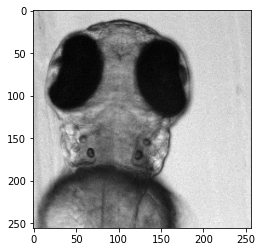

In [22]:
plt.imshow(img_test.squeeze()[10,...], cmap='gray')

In [23]:
# prediction
from timeit import default_timer as timer

start = timer()
pred_test = my_model.predict(img_test)
end = timer()

print('DNN time:', end-start)
print(pred_test.shape, pred_test.min(), pred_test.max())

DNN time: 0.054207151057198644
(20, 256, 256, 1) 2.3624103e-33 1.0


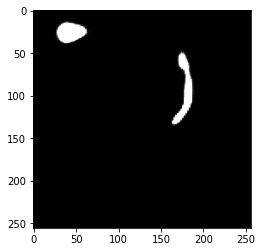

In [29]:
plt.imshow(pred_test.squeeze()[18,...]*255, cmap='gray')